### important: whenever you make changes to an imported notebook you need to select "restart the kernel" in this notebook to load the changes then rerun the cells

In [1]:
# I think we need to include the individual inputs in each file

# #All imports from everywhere
# import copy
# import cv2
# import imutils
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# from PIL import ImageColor
# from skimage import exposure
# from skimage.measure import label, regionprops
# from skimage.morphology import area_opening, disk, square
# import sys

In [2]:
# parameters

REFERENCE_MISSION = 2
mission_numbers = [REFERENCE_MISSION, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]

# Alex - anomaly detection
BBOX_COLOR = (255, 0, 0)
DEBUG_IMAGES = False
NUM_BBOX_ITERATIONS = 2

In [3]:
import import_ipynb
# import KyleFunctions as KF # TODO code needs to be put into function format
import AlexFunctions as AF
import LoadData as LD
import VisualizeResults as VR

# KF.kyle_print("test")
# regions = AF.setup_regions_and_images()
# AF.plot_images(regions)

importing Jupyter notebook from AlexFunctions.ipynb
importing Jupyter notebook from LoadData.ipynb
importing Jupyter notebook from VisualizeResults.ipynb


# Load Data

In [4]:
# load all of the images and regions (bgr, hsv, histogram)
data = LD.run_load_data(mission_numbers, debug_images=False)

mission_images_bgr = data[0]
grass_images_bgr = data[1]
building_images_bgr = data[2]
histogram_mission_images_bgr = data[3]
histogram_grass_images_bgr = data[4]
histogram_building_images_bgr = data[5]
mission_images_hsv = data[6]
histogram_mission_images_hsv = data[7]
histogram_grass_images_hsv = data[8]
histogram_building_images_hsv = data[9]

Loading Missions: [2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]
Data Loaded


# Anomaly Detection

In [5]:
# Kyle - anomaly detection


# Alex - anomaly detection
# bbox_masks, num_bboxs, superimposed_images = AF.anomaly_detection_1(mission_numbers, mission_images_hsv, histogram_mission_images_bgr, histogram_mission_images_hsv, num_bbox_iterations=NUM_BBOX_ITERATIONS, bbox_color=BBOX_COLOR, debug_images=False)

# print(num_bboxs)
# AF.plot_images(bbox_masks, ['bbox_masks ' + str(mission_number) for mission_number in mission_numbers])
# AF.plot_images(superimposed_images, ['superimposed_images ' + str(mission_number) for mission_number in mission_numbers])

# Heatmap

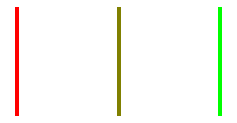

[[34.175562996520256, 31.34869673691813, 1.4995732387893113], [34.20602718140634, 31.062701070185806, 1.7551047206355461], [34.2254612303854, 31.079508896329855, 1.7188628455124417], [34.340489790558735, 30.823714792200118, 1.8596283894688463], [0.7642308449871972, 64.92731928304116, 1.3322828441993304], [34.63856608233208, 31.639682227036964, 0.7455846628586436], [34.79666469699954, 30.641192305167092, 1.5859759700610598], [34.984177007419085, 30.443962970258028, 1.5956929945505878], [34.91773356969339, 30.776442781169983, 1.3296566213643228], [33.79344757402666, 33.21147659378899, 0.018908804412054364], [33.851749720963824, 33.155800669686826, 0.01628258157704681], [34.09598844461952, 26.797452563850044, 6.130391963758125]]
67.0238329722277
67.0238329722277
67.02383297222771
67.02383297222771
67.02383297222768
67.0238329722277
67.0238329722277
67.02383297222771
67.0238329722277
67.0238329722277
67.0238329722277
67.0238329722277


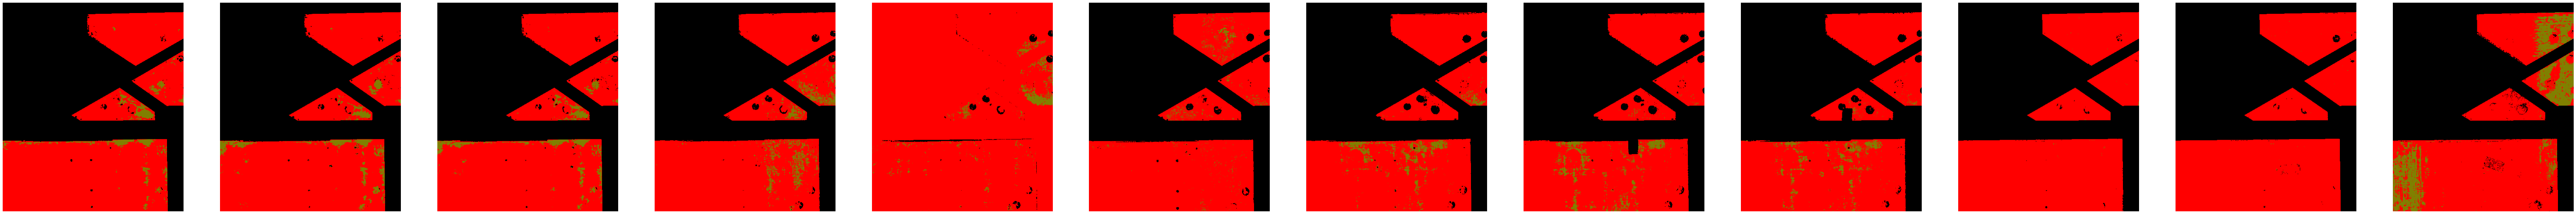

In [10]:
# Kyle - heatmap
import import_ipynb
import numpy as np
# import KyleFunctions as KF # TODO code needs to be put into function format
import KyleFunctions as KF
import LoadData as LD
import VisualizeResults as VR

heatmap,percents = KF.score_missions(histogram_grass_images_bgr,3)
print(percents)
AF.plot_images(image_list=heatmap)
for each in percents:
    print(np.sum(each))

# Roof

In [ ]:
# Josh - roof


# Visualize Output

In [ ]:
# combine the bounding boxes from anomaly detection
# combine the heatmap and roof mask
# display histograms, plots, metrics, etc

# VR.run_visualize_results(mission_numbers, bboxs, histogram_mission_images_bgr, heatmaps, roof_masks, percent_roof_pixels, debug_images=DEBUG_IMAGES):